In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
import geopandas as gpd

import os
import sys
from glob import glob

import re

In [2]:
root = os.path.split(sys.path[0])[0]
output_folder = os.path.join(root, 'output')

In [3]:
files = dict(map(lambda x: (os.path.split(x)[-1].split('.')[0], x), 
                 glob(os.path.join(output_folder, '*'))))
files

{'location_lookup': '/home/msds2020/cdavid/DMW lab/lab 1/elections/coding exercise/output/location_lookup.csv',
 'denorm_pres': '/home/msds2020/cdavid/DMW lab/lab 1/elections/coding exercise/output/denorm_pres.csv',
 'denorm_vice': '/home/msds2020/cdavid/DMW lab/lab 1/elections/coding exercise/output/denorm_vice.csv'}

In [7]:
output_folder

'/home/msds2020/cdavid/DMW lab/lab 1/elections/coding exercise/output'

In [4]:
def clean_income_class(text):
    if isinstance(text, str):
        if 'Special' in text:
            return text
        if len(text) < 2 or text.isalnum() == False: 
            return np.nan
        else:
            return text.split()[0]
    return np.nan

In [17]:
df_pres = pd.read_csv(files['denorm_pres'])
# .sample(frac=0.01)
# df_pres.timestamp = pd.to_datetime(df_pres.timestamp)
# df_pres.income_class = df_pres.income_class.apply(clean_income_class)
df_pres.head()

,precinct_code,region,gadm_province,gadm_municipality,barangay,candidate_name,party_code,votes,ballots_cast,abstain,invalid_votes,timestamp,pct_votes,registered_voters,is_city,income_class,population,land_area
0,10050007,REGION IV-A,Batangas,Batangas City,BARANGAY 5 (POB.),"DUTERTE, RODY (PDPLBN)",114,168,491,2,0,2016-05-09 18:28:46,0.342159,602.0,1.0,1st Class-Special,NaN,28296.0
1,10050007,REGION IV-A,Batangas,Batangas City,BARANGAY 5 (POB.),"DEFENSOR SANTIAGO, MIRIAM (PRP)",135,35,491,2,0,2016-05-09 18:28:46,0.071283,602.0,1.0,1st Class-Special,NaN,28296.0
2,10050007,REGION IV-A,Batangas,Batangas City,BARANGAY 5 (POB.),"BINAY, JOJO (UNA)",163,88,491,2,0,2016-05-09 18:28:46,0.179226,602.0,1.0,1st Class-Special,NaN,28296.0
3,10050007,REGION IV-A,Batangas,Batangas City,BARANGAY 5 (POB.),"ROXAS, MAR DAANG MATUWID (LP)",85,82,491,2,0,2016-05-09 18:28:46,0.167006,602.0,1.0,1st Class-Special,NaN,28296.0
4,10050007,REGION IV-A,Batangas,Batangas City,BARANGAY 5 (POB.),"SEÑERES, ROY (WPPPMM)",165,1,491,2,0,2016-05-09 18:28:46,0.002037,602.0,1.0,1st Class-Special,NaN,28296.0


In [20]:
df_pres.income_class.unique()

array(['1st Class-Special', '2nd', '3rd', '1st', nan, '5th', '4th', '6th'],
      dtype=object)

In [16]:
# df_pres.to_csv(os.path.join(output_folder, 'denorm_pres.csv'), index=False)

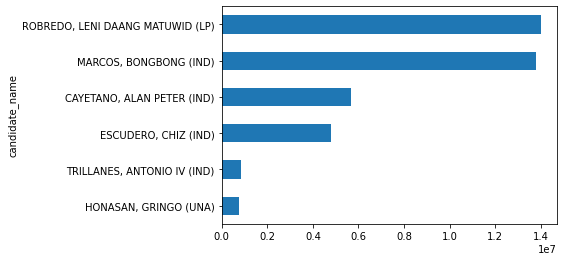

In [6]:
df_pres.groupby('candidate_name').votes.sum().sort_values().plot(kind='barh')

# candidate stats

In [274]:
df_time = pd.crosstab(df_pres.timestamp, df_pres.candidate_name, df_pres.votes, aggfunc='sum').resample('H').sum()

In [278]:
df_cumsum = df_time.cumsum(axis=0)

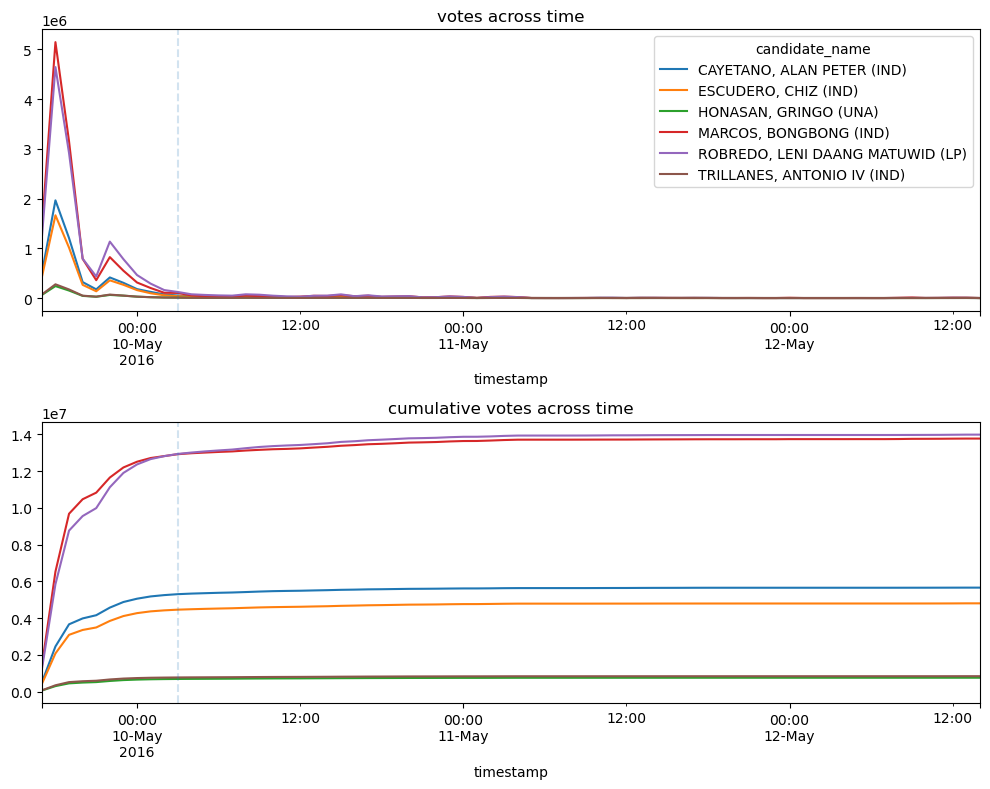

In [283]:
fig, ax = plt.subplots(2, 1,figsize=(10, 8), dpi=100)
df_time.plot(ax=ax[0])
df_cumsum.plot(ax=ax[1], legend=None)
ax[0].set_title('votes across time')
ax[1].set_title('cumulative votes across time')
for axx in ax:
    line = df_cumsum[df_cumsum.iloc[:, 4] > df_cumsum.iloc[:, 3]].index[0]
    axx.axvline(line, alpha=0.2, linestyle='dashed')
fig.tight_layout()

In [474]:
df = df_pres[df_pres.timestamp >= line].groupby(['candidate_name', 'region']).votes.sum().unstack()
df = df.div(df.sum(axis=0))

In [475]:
df_plot = pd.DataFrame()
df_plot['robredo'] = df.iloc[4, :].T
df_plot['others'] = df.iloc[[0,1,2,5]].sum(axis=0)
df_plot['marcos'] = df.iloc[3, :].T

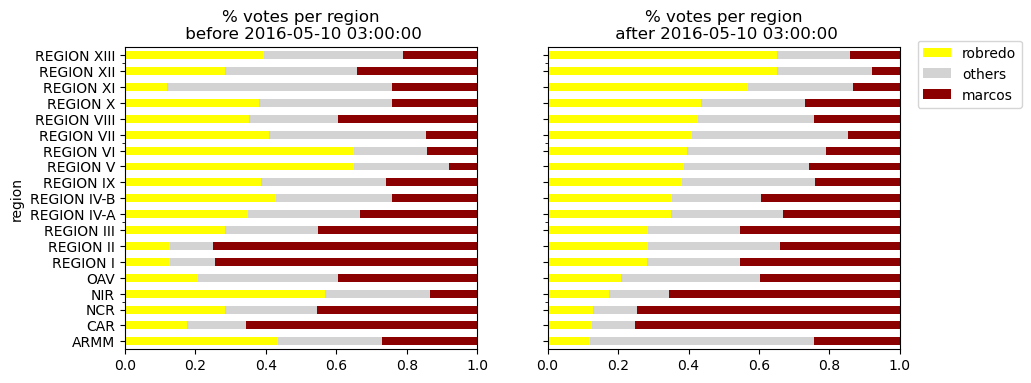

In [485]:
fig, ax =plt.subplots(1, 2, figsize=(10, 4), dpi=100, sharey=True)
df_plot.sort_values(by='robredo').plot(kind='barh', 
                                       stacked=True, 
                                       color=['yellow', 'lightgray', 'darkred'], 
                                       ax=ax[1])
ax[1].legend(loc=(1.05,0.8))
ax[1].set_xlim(0,1)
ax[1].set_title(f'% votes per region\n after {line}');


df = df_pres[df_pres.timestamp < line].groupby(['candidate_name', 'region']).votes.sum().unstack()
df = df.div(df.sum(axis=0))
df_plot = pd.DataFrame()
df_plot['robredo'] = df.iloc[4, :].T
df_plot['others'] = df.iloc[[0,1,2,5]].sum(axis=0)
df_plot['marcos'] = df.iloc[3, :].T
df_plot = df_plot.loc[pos, :]
# fig, ax =plt.subplots(figsize=(8, 4), dpi=100)
df_plot.plot(kind='barh', 
                                       stacked=True, 
                                       color=['yellow', 'lightgray', 'darkred'], 
                                       ax=ax[0], legend=None)
# ax[0].legend(loc=(1.05,0.85))
ax[0].set_xlim(0,1)
ax[0].set_title(f'% votes per region\n before {line}');

In [464]:
pos = df_plot.index

In [465]:
df = df_pres[df_pres.timestamp < line].groupby(['candidate_name', 'region']).votes.sum().unstack()
df = df.div(df.sum(axis=0))
# df_pres[df_pres.timestamp < line].groupby(['candidate_name', 'region']).votes.sum().unstack()

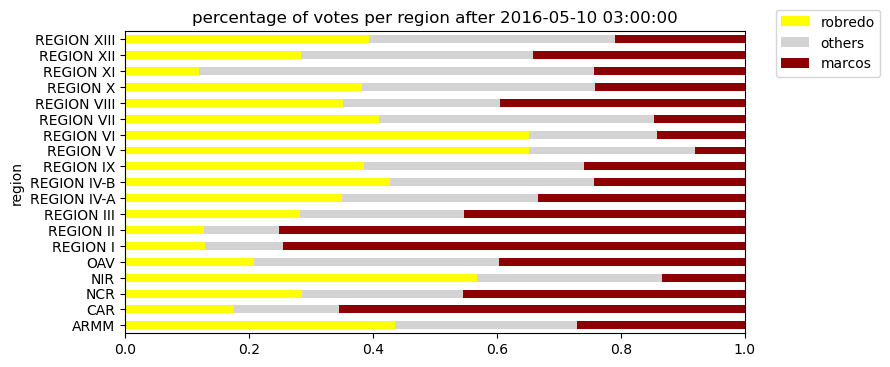

# population density
** excluding NCR 

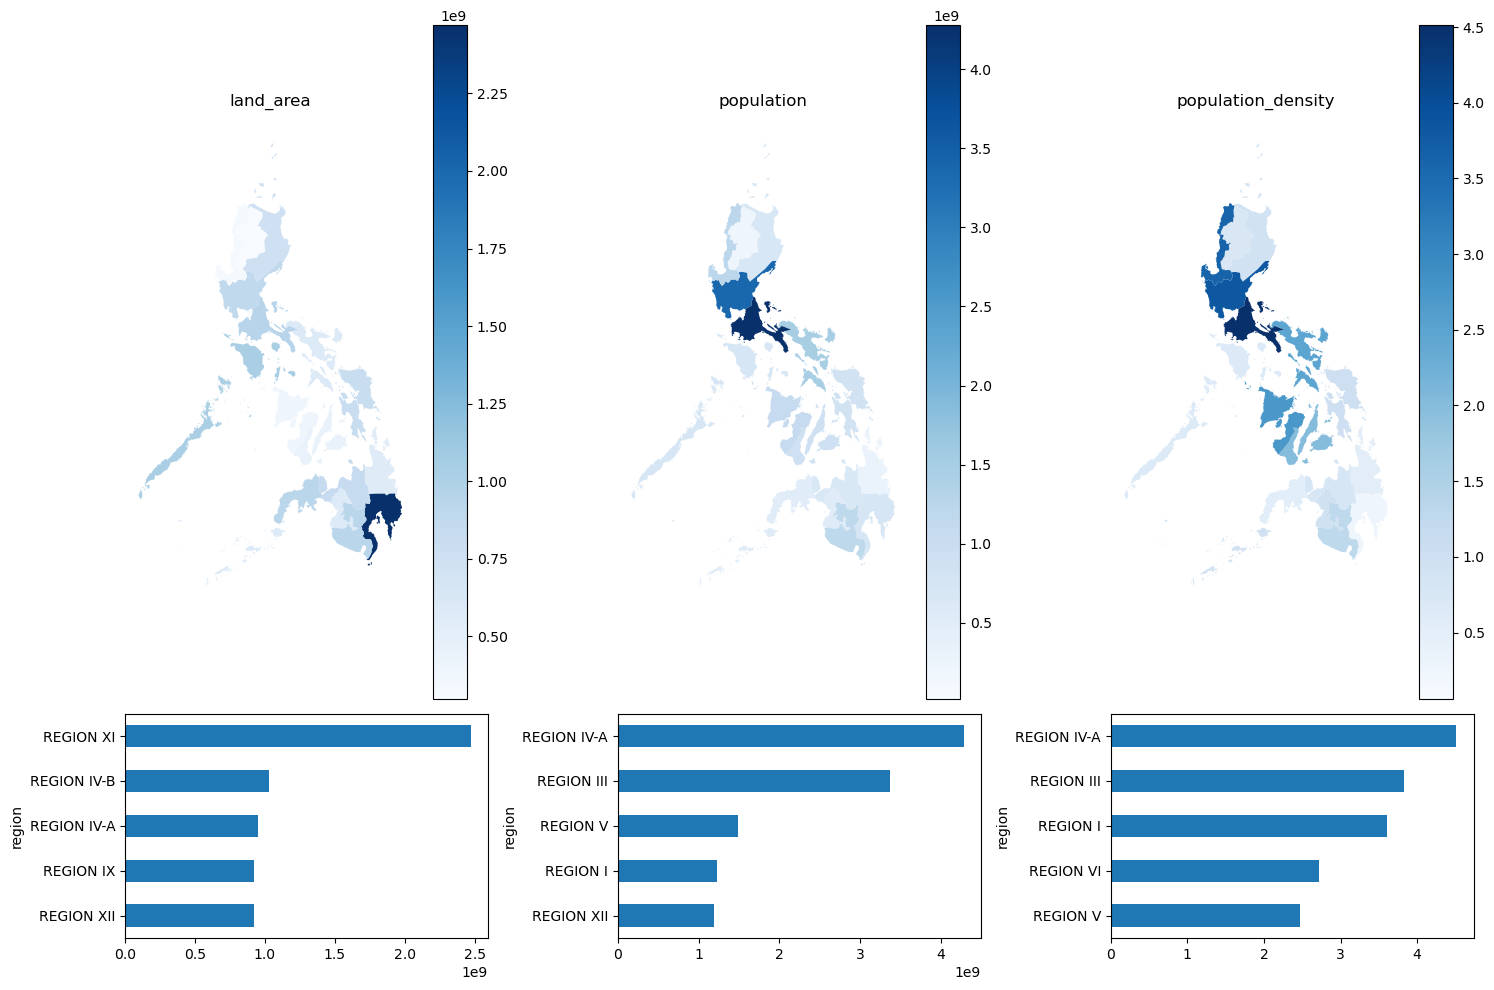

In [133]:
cmap='Blues'

fig, ax = plt.subplots(2,3, figsize=(15,10), dpi=100, gridspec_kw={'height_ratios': [3, 1]})
ind=0
for col in ['land_area', 'population']:
    merged = regions.merge(df_region_stats[col].sum().reset_index())
    merged.plot(column=col, cmap=cmap, legend=True, ax=ax[0][ind])
    ax[0][ind].axis('off')
    ax[0][ind].set_title(col)
    merged = merged.set_index('region')
    merged[col].sort_values(ascending=False).head(5).sort_values().plot(kind='barh', ax=ax[1][ind])
    ind += 1
merged = regions.merge((df_region_stats['population'].sum() / 
                        df_region_stats['land_area'].sum()).dropna().reset_index())
merged.plot(column=0, cmap=cmap, legend=True, ax=ax[0][2])
ax[0][2].axis('off')
ax[0][2].set_title('population_density')

merged = merged.set_index('region')
merged[0].sort_values(ascending=False).head(5).sort_values().plot(kind='barh', ax=ax[1][2])
ax[1][2];
fig.tight_layout();

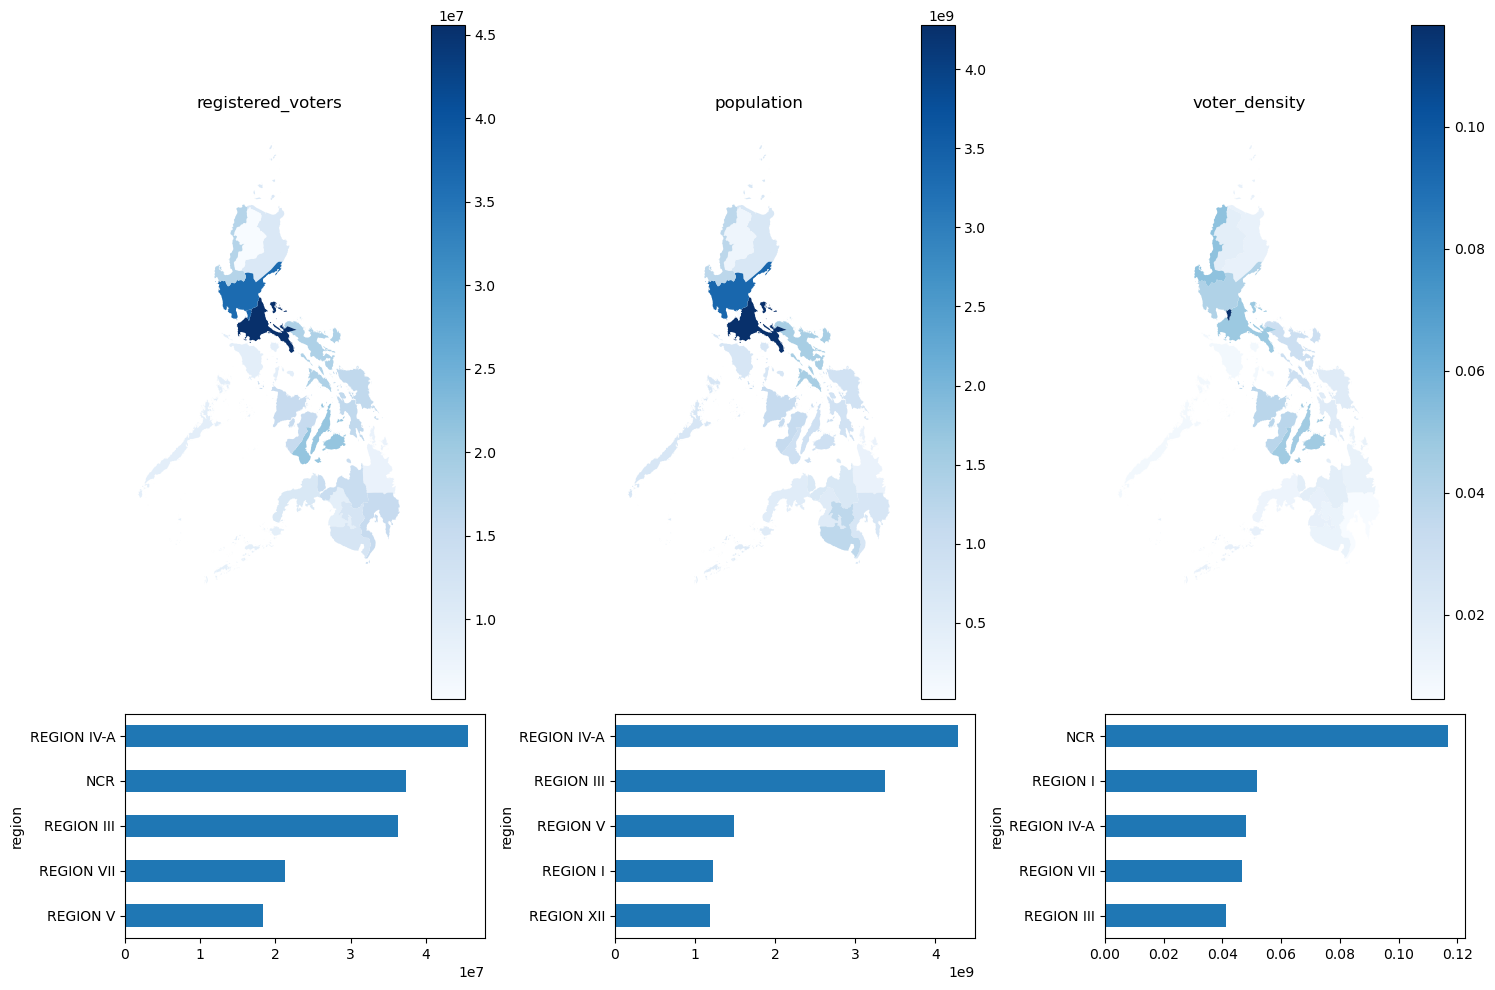

In [134]:
cmap='Blues'

fig, ax = plt.subplots(2,3, figsize=(15,10), dpi=100, gridspec_kw={'height_ratios': [3, 1]})
ind=0
for col in ['registered_voters', 'population']:
    merged = regions.merge(df_region_stats[col].sum().reset_index())
    merged.plot(column=col, cmap=cmap, legend=True, ax=ax[0][ind])
    ax[0][ind].axis('off')
    ax[0][ind].set_title(col)
    merged = merged.set_index('region')
    merged[col].sort_values(ascending=False).head(5).sort_values().plot(kind='barh', ax=ax[1][ind])
    ind += 1
merged = regions.merge((df_region_stats['registered_voters'].sum() / 
                        df_region_stats['land_area'].sum()).dropna().reset_index())
merged.plot(column=0, cmap=cmap, legend=True, ax=ax[0][2])
ax[0][2].axis('off')
ax[0][2].set_title('voter_density')

merged = merged.set_index('region')
merged[0].sort_values(ascending=False).head(5).sort_values().plot(kind='barh', ax=ax[1][2])
ax[1][2];
fig.tight_layout();

In [23]:
regions = gpd.GeoDataFrame.from_file('Regions.shp')
# .plot()

In [68]:
def clean(text):
    try:
        if 'Metro' in text:
            return 'NCR'
        else:
            return re.findall('\((.*?)\)', text)[0].upper()
    except:
        return text.upper()

In [73]:
regions['region'] = regions.REGION.apply(clean)
regions = regions.drop(columns=['REGION']).copy()

In [131]:
df_region_stats = df_pres.groupby('region')

In [489]:
df_pres.groupby(['region', 'gadm_province', 'gadm_municipality', 'income_class']).votes.sum().unstack()

income_class                                          -  -   1st  \
region      gadm_province   gadm_municipality                      
ARMM        Basilan         Akbar                5116.0 NaN  NaN   
                            Al-Barka             5820.0 NaN  NaN   
                            HADJI MUHTAMAD       5001.0 NaN  NaN   
                            Hadji Mohammad Ajul  6588.0 NaN  NaN   
                            Isabela City            NaN NaN  NaN   
...                                                 ...  ..  ...   
REGION XIII Surigao del Sur Madrid                  NaN NaN  NaN   
                            Marihatag               NaN NaN  NaN   
                            Tagbina                 NaN NaN  NaN   
                            Tago                    NaN NaN  NaN   
                            Tandag City             NaN NaN  NaN   

income_class                                     1st Class-Special     2nd  \
region      gadm_province   gadm_municipality                                
ARMM        Basilan         Akbar                              NaN     NaN   
                            Al-Barka                           NaN     NaN   
                            HADJI MUHTAMAD                     NaN     NaN   
                            Hadji Mohammad Ajul                NaN     NaN   
                            Isabela City                       NaN     NaN   
...                                                            ...     ...   
REGION XIII Surigao del Sur Madrid                             NaN     NaN   
                            Marihatag                          NaN     NaN   
                            Tagbina                            NaN  8518.0   
                            Tago                               NaN  7785.0   
                            Tandag City                        NaN     NaN   

income_class                                     2nd Class      3rd  \
region      gadm_province   gadm_municipality                         
ARMM        Basilan         Akbar                       NaN     NaN   
                            Al-Barka                    NaN     NaN   
                            HADJI MUHTAMAD              NaN     NaN   
                            Hadji Mohammad Ajul         NaN     NaN   
                            Isabela City                NaN     NaN   
...                                                     ...     ...   
REGION XIII Surigao del Sur Madrid                      NaN     NaN   
                            Marihatag                   NaN  6841.0   
                            Tagbina                     NaN     NaN   
                            Tago                        NaN     NaN   
                            Tandag City                 NaN     NaN   

income_class                                     3rd Class      4th  \
region      gadm_province   gadm_municipality                         
ARMM        Basilan         Akbar                       NaN     NaN   
                            Al-Barka                    NaN     NaN   
                            HADJI MUHTAMAD              NaN     NaN   
                            Hadji Mohammad Ajul         NaN     NaN   
                            Isabela City                NaN     NaN   
...                                                     ...     ...   
REGION XIII Surigao del Sur Madrid                      NaN  6332.0   
                            Marihatag                   NaN     NaN   
                            Tagbina                     NaN     NaN   
                            Tago                        NaN     NaN   
                            Tandag City                 NaN     NaN   

income_class                                     4th Class   5th  5th Class   \
region      gadm_province   gadm_municipality                                  
ARMM        Basilan         Akbar                       NaN  NaN         NaN   
            

In [24]:
regions

,REGION,geometry
0,Autonomous Region of Muslim Mindanao (ARMM),"MULTIPOLYGON (((119.46694 4.58694, 119.46639 4..."
1,Bicol Region (Region V),"MULTIPOLYGON (((122.98417 11.71056, 122.98333 ..."
2,CALABARZON (Region IV-A),"MULTIPOLYGON (((125.22166 10.43444, 125.22195 ..."
3,Cagayan Valley (Region II),"MULTIPOLYGON (((122.47040 16.91995, 122.47040 ..."
4,Caraga (Region XIII),"MULTIPOLYGON (((126.41750 7.96417, 126.41778 7..."
5,Central Luzon (Region III),"MULTIPOLYGON (((120.62363 14.36788, 120.62368 ..."
6,Central Visayas (Region VII),"MULTIPOLYGON (((123.27111 9.08476, 123.27173 9..."
7,Cordillera Administrative Region (CAR),"POLYGON ((121.37679 17.95473, 121.36825 17.939..."
8,Davao Region (Region XI),"MULTIPOLYGON (((125.39778 5.43583, 125.39778 5..."
9,Eastern Visayas (Region VIII),"MULTIPOLYGON (((125.07361 9.89472, 125.07333 9..."


In [571]:
df_pres.dtypes

precinct_code                 int64
region                       object
gadm_province                object
gadm_municipality            object
barangay                     object
candidate_name               object
party_code                    int64
votes                         int64
ballots_cast                  int64
abstain                       int64
invalid_votes                 int64
timestamp            datetime64[ns]
pct_votes                   float64
registered_voters           float64
is_city                     float64
income_class                 object
population                  float64
land_area                   float64
dtype: object